In [ ]:

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
#
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/amazon_polarity/dataset_dict.json
/kaggle/input/amazon_polarity/test/state.json
/kaggle/input/amazon_polarity/test/dataset_info.json
/kaggle/input/amazon_polarity/test/data-00000-of-00001.arrow
/kaggle/input/amazon_polarity/train/state.json
/kaggle/input/amazon_polarity/train/dataset_info.json
/kaggle/input/amazon_polarity/train/data-00000-of-00001.arrow


In [3]:
# Source directory
import shutil

file_name = "amazon_polarity"
source_dir = f"/kaggle/input/{file_name}"

# Destination directory
destination_dir = f"/kaggle/working/{file_name}"

shutil.copytree(source_dir, destination_dir)


'/kaggle/working/amazon_polarity'

In [4]:
import datasets
from transformers import BertTokenizerFast, TFBertForSequenceClassification, BertModel, create_optimizer,TFRobertaForSequenceClassification,  TFBertModel, RobertaTokenizerFast
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

2024-07-07 03:22:56.019927: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-07 03:22:56.020053: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-07 03:22:56.153329: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
dataset  = datasets.load_from_disk('/kaggle/working/amazon_polarity')

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'label_text'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['label', 'text', 'label_text'],
        num_rows: 50000
    })
})

In [7]:
dataset['test'] = dataset['test'].shuffle(seed=42).select(range(20000))
dataset['train'] = dataset['train'].shuffle(seed=42).select(range(80000))

In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'label_text'],
        num_rows: 80000
    })
    test: Dataset({
        features: ['label', 'text', 'label_text'],
        num_rows: 20000
    })
})

In [9]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

#### Helper Function for model evaluation

In [10]:
def get_prediction(model, tokenizer, have_token_type_ids=False):
    test_data = dataset['test'].to_tf_dataset(columns=['text'], label_cols=["label"])
    test_sentences = test_data.map(lambda x,y: x)
    labels = test_data.map(lambda x,y: y)
    
    y_true = np.array([label.numpy() for label in labels])
        
    test_sentences = list(test_sentences.as_numpy_iterator())
    test_sentences = [i.decode('utf-8') for i in test_sentences]

    inp = tokenizer(test_sentences, padding="max_length",
                         truncation=True, max_length=200)
    
    input_ids = np.array(inp['input_ids']) 
    attention_mask = np.array(inp['attention_mask'])

    if have_token_type_ids:
        token_type_ids = np.array(inp['token_type_ids'])
        predictions = model.predict({'input_ids': input_ids,
                                     'token_type_ids':token_type_ids, 
                                     'attention_mask': attention_mask})['logits']
        
    else:
        predictions = model.predict({'input_ids': input_ids, 
                                     'attention_mask': attention_mask})['logits']
        
    
    predictions_2 = tf.nn.sigmoid(predictions)
    y_pred = np.argmax(predictions, axis=1)
    
    return y_true, y_pred
        

In [11]:
def get_model_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    preci = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    recal = recall_score(y_true, y_pred)
    return {'Accuracy': acc, 'f1_score': f1, 'Precision': preci, 'Recall':recal}


def plot_confusion_matrix(y_true, y_pred, saved_name):
    disp = ConfusionMatrixDisplay.from_predictions(
          y_true, y_pred, 
          labels=[0,1], 
          display_labels=['Negative', 'Positive'], 
          # normalize='true', 
          cmap=plt.cm.Blues
      )

    ax = disp.ax_
    ax.set_title(f'Confusion Matrix for {saved_name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual' )

    plt.savefig(f'/kaggle/working/{saved_name}.png')
    plt.show()

# BERT Models

In [12]:
model_id="bert-base-uncased"
bert_tokenizer = BertTokenizerFast.from_pretrained(model_id)
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
def preprocess_function(examples):
    return bert_tokenizer(examples["text"],padding="max_length",truncation=True, max_length=200)


In [14]:
tokenized_dataset_bert = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/80000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

In [15]:
BATCH_SIZE = 16

train_dataset_bert = tokenized_dataset_bert["train"].to_tf_dataset(
    columns=[  'input_ids', 'token_type_ids', 'attention_mask'],
    label_cols=["label"],
    shuffle=True, 
    batch_size=BATCH_SIZE)

test_dataset_bert = tokenized_dataset_bert["test"].to_tf_dataset(
    columns=[ 'input_ids','token_type_ids', 'attention_mask'],
    label_cols=["label"],
    shuffle=True,
    batch_size=BATCH_SIZE)


/opt/conda/lib/python3.10/site-packages/datasets/arrow_dataset.py:410: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [16]:
num_epochs = 4
BATCH_SIZE = BATCH_SIZE
batches_per_epoch = len(tokenized_dataset_bert["train"]) // BATCH_SIZE
total_train_steps = int(batches_per_epoch * num_epochs)

optimizer, schedule = create_optimizer(init_lr=2e-5,num_warmup_steps=0, num_train_steps=total_train_steps)

In [17]:
bert_model.compile(
    optimizer=optimizer,
    metrics=['accuracy',])

In [18]:
# with tf.device('/device:GPU:0'):

with tf.device('/device:GPU:0'):
    bert_history=bert_model.fit(
        train_dataset_bert,
        validation_data=test_dataset_bert, 
        epochs=4, verbose=1)


Epoch 1/4
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


I0000 00:00:1720322709.313555     110 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5000/5000 [==============================] - 3730s 728ms/step - loss: 0.1552 - accuracy: 0.9406 - val_loss: 0.1305 - val_accuracy: 0.9541
Epoch 2/4
5000/5000 [==============================] - 3629s 726ms/step - loss: 0.0749 - accuracy: 0.9751 - val_loss: 0.1447 - val_accuracy: 0.9553
Epoch 3/4
5000/5000 [==============================] - 3632s 726ms/step - loss: 0.0325 - accuracy: 0.9909 - val_loss: 0.1716 - val_accuracy: 0.9536
Epoch 4/4
5000/5000 [==============================] - 3629s 726ms/step - loss: 0.0162 - accuracy: 0.9964 - val_loss: 0.2144 - val_accuracy: 0.9541


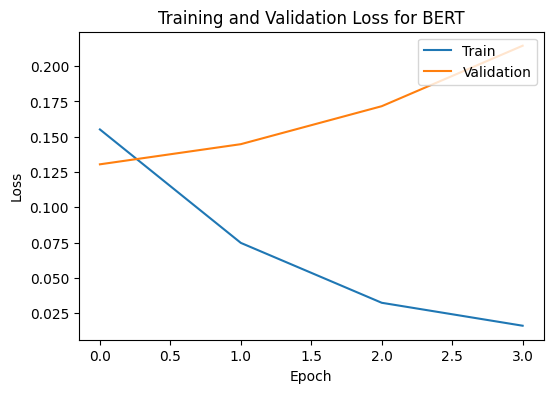

In [19]:
plt.figure(figsize=(6,4))
plt.plot(bert_history.history['loss'])
plt.plot(bert_history.history['val_loss'])
plt.title('Training and Validation Loss for BERT')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig('/kaggle/working/bert_los.png')
plt.show()

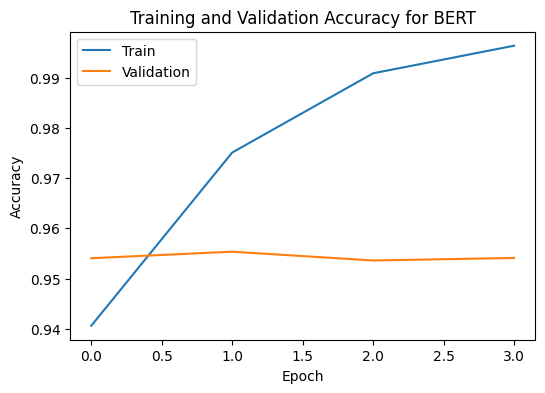

In [20]:
plt.figure(figsize=(6,4))
plt.plot(bert_history.history['accuracy'])
plt.plot(bert_history.history['val_accuracy'])
plt.title('Training and Validation Accuracy for BERT')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('/kaggle/working/bert_acc.png')
plt.show()

In [ ]:
bert_history.history

In [ ]:
get_model_metrics(y_true1, y_pred1)

In [ ]:
get_model_metrics(y_true, y_pred_3)

In [ ]:
plot_confusion_matrix(y_true, y_pred_3, "Bert Model")

In [ ]:
bert_model.save_pretrained('/kaggle/working/bert_model')
bert_tokenizer.save_pretrained('/kaggle/working/bert_tokenizer')

# Roberta Model


In [21]:
model_id="roberta-base"
roberta_tokenizer=RobertaTokenizerFast.from_pretrained(model_id)
roberta_model=TFRobertaForSequenceClassification.from_pretrained(model_id,num_labels=2)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

In [22]:
def preprocess_function(examples):
    return roberta_tokenizer(examples["text"],padding='max_length',truncation=True, max_length=200)


In [23]:
tokenized_dataset_roberta = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/80000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

In [25]:
tokenized_dataset_roberta

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'label_text', 'input_ids', 'attention_mask'],
        num_rows: 80000
    })
    test: Dataset({
        features: ['label', 'text', 'label_text', 'input_ids', 'attention_mask'],
        num_rows: 20000
    })
})

In [26]:
BATCH_SIZE = 16

In [27]:
train_dataset_roberta = tokenized_dataset_roberta["train"].to_tf_dataset(
    columns=[  'input_ids', 'attention_mask'],
    label_cols=["label"],
    shuffle=True, 
    batch_size=BATCH_SIZE)

test_dataset_roberta = tokenized_dataset_roberta["test"].to_tf_dataset(
    columns=[ 'input_ids', 'attention_mask'],
    label_cols=["label"],
    shuffle=True,
    batch_size=BATCH_SIZE)


In [28]:
num_epochs = 7
batches_per_epoch = len(tokenized_dataset_roberta["train"]) // BATCH_SIZE
total_train_steps = int(batches_per_epoch * num_epochs)

optimizer, schedule = create_optimizer(init_lr=2e-5,num_warmup_steps=0, num_train_steps=total_train_steps)

In [29]:

roberta_model.compile(#loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=optimizer,
    metrics=['accuracy'],)
    #run_eagerly=True)

In [30]:
with tf.device('/device:GPU:0'):
    roberta_history=roberta_model.fit(
        train_dataset_roberta,
        validation_data=test_dataset_roberta,
        epochs=7,callbacks=[early_stop_callback])

Epoch 1/7
5000/5000 [==============================] - 3724s 731ms/step - loss: 0.1419 - accuracy: 0.9485 - val_loss: 0.1142 - val_accuracy: 0.9596
Epoch 2/7
5000/5000 [==============================] - 3633s 727ms/step - loss: 0.0906 - accuracy: 0.9686 - val_loss: 0.1284 - val_accuracy: 0.9587
Epoch 3/7
5000/5000 [==============================] - 3634s 727ms/step - loss: 0.0605 - accuracy: 0.9805 - val_loss: 0.1214 - val_accuracy: 0.9606
Epoch 4/7
5000/5000 [==============================] - 3636s 727ms/step - loss: 0.0375 - accuracy: 0.9893 - val_loss: 0.1588 - val_accuracy: 0.9593
Epoch 5/7
5000/5000 [==============================] - 3636s 727ms/step - loss: 0.0254 - accuracy: 0.9935 - val_loss: 0.1637 - val_accuracy: 0.9609


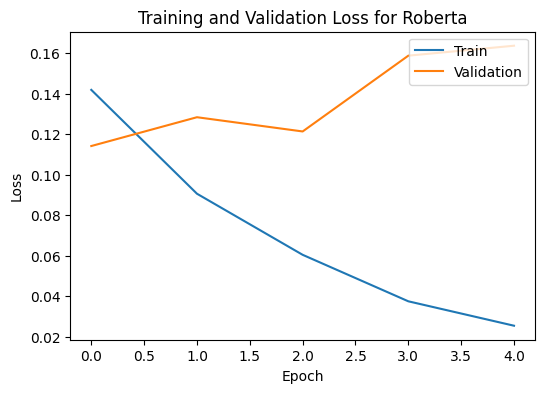

In [31]:
plt.figure(figsize=(6,4))
plt.plot(roberta_history.history['loss'])
plt.plot(roberta_history.history['val_loss'])
plt.title('Training and Validation Loss for Roberta')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig('/kaggle/working/roberta_los.png')
plt.show()

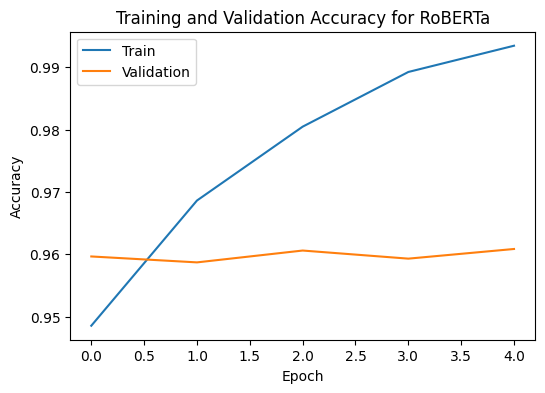

In [32]:
plt.figure(figsize=(6,4))
plt.plot(roberta_history.history['accuracy'])
plt.plot(roberta_history.history['val_accuracy'])
plt.title('Training and Validation Accuracy for RoBERTa')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('/kaggle/working/roberta_acc.png')
plt.show()

### Roberta Evaluation

In [ ]:
roberta_history.history

In [ ]:
y_true_ro, y_pred_ro = get_prediction(roberta_model, roberta_tokenizer, have_token_type_ids=False)


In [ ]:
roberta_metrics = get_model_metrics(y_true_ro, y_pred_ro)
roberta_metrics

In [ ]:
plot_confusion_matrix(y_true_ro, y_pred_ro, "RoBERTa Model")

# DistilBERT

In [12]:
from transformers import TFDistilBertForSequenceClassification, DistilBertTokenizerFast

import tensorflow as tf

distilbert_tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
distilbert_model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [13]:
def tokenize_fn(examples):
    return distilbert_tokenizer(examples["text"],padding='max_length',truncation=True, max_length=200)


In [14]:
tokenized_dataset_distilbert = dataset.map(tokenize_fn, batched=True)


Map:   0%|          | 0/80000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

In [15]:
BATCH_SIZE=16
train_dataset_distilbert = tokenized_dataset_distilbert["train"].to_tf_dataset(
    columns=[  'input_ids', 'attention_mask'],
    label_cols=["label"],
    shuffle=True, 
    batch_size=BATCH_SIZE)

test_dataset_distilbert = tokenized_dataset_distilbert["test"].to_tf_dataset(
    columns=[ 'input_ids', 'attention_mask'],
    label_cols=["label"],
    shuffle=True,
    batch_size=BATCH_SIZE)


/opt/conda/lib/python3.10/site-packages/datasets/arrow_dataset.py:410: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [16]:
num_epochs = 10
batches_per_epoch = len(tokenized_dataset_distilbert["train"]) // BATCH_SIZE
total_train_steps = int(batches_per_epoch * num_epochs)

optimizer, schedule = create_optimizer(init_lr=2e-5,num_warmup_steps=0, num_train_steps=total_train_steps)



In [17]:



distilbert_model.compile(#loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=optimizer,
    metrics=['accuracy'],)
    #run_eagerly=True)

In [ ]:
with tf.device('/device:GPU:0'):
    disert_history=distilbert_model.fit(
        train_dataset_distilbert,
        validation_data=test_dataset_distilbert, 
        epochs=10, verbose=1, callbacks=[early_stop_callback])


Epoch 1/10
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


I0000 00:00:1720111258.047752      93 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5000/5000 [==============================] - 1847s 358ms/step - loss: 0.1743 - accuracy: 0.9330 - val_loss: 0.1447 - val_accuracy: 0.9464
Epoch 2/10
5000/5000 [==============================] - 1798s 360ms/step - loss: 0.0958 - accuracy: 0.9666 - val_loss: 0.1503 - val_accuracy: 0.9503
Epoch 3/10
  48/5000 [..............................] - ETA: 27:15 - loss: 0.0400 - accuracy: 0.9922

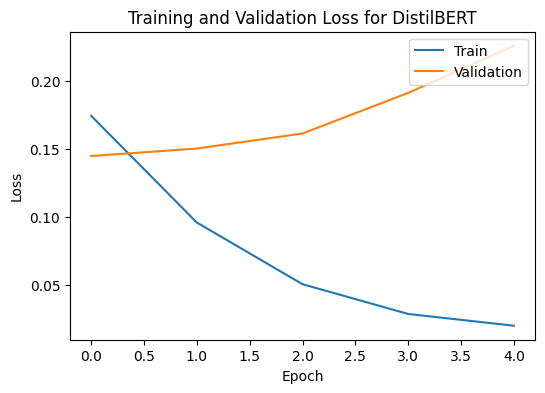

In [21]:
plt.figure(figsize=(6,4))
plt.plot(distilbert_history.history['loss'])
plt.plot(distilbert_history.history['val_loss'])
plt.title('Training and Validation Loss for DistilBERT')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig('/kaggle/working/distilbert_los.png')
plt.show()

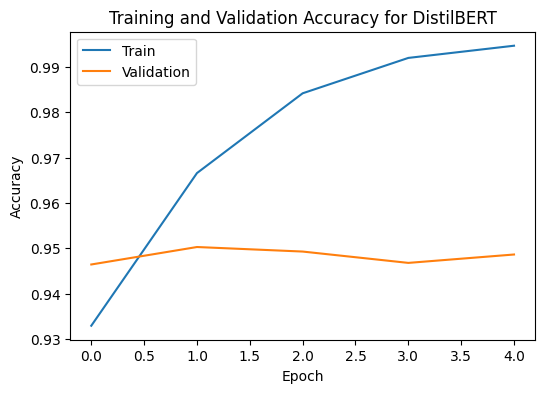

In [22]:
plt.figure(figsize=(6,4))
plt.plot(distilbert_history.history['accuracy'])
plt.plot(distilbert_history.history['val_accuracy'])
plt.title('Training and Validation Accuracy for DistilBERT')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('/kaggle/working/distilbert_acc.png')
plt.show()

### Save the model


In [ ]:
distilbert_history.history

In [ ]:
y_true_dis, y_pred_dis = get_prediction(distilbert_model, distilbert_tokenizer, have_token_type_ids=False)


In [ ]:
distilbert_metrics = get_model_metrics(y_true_dis, y_pred_dis)


In [ ]:
distilbert_metrics

In [ ]:
plot_confusion_matrix(y_true_dis, y_pred_dis, "DistilBERT Model")

In [ ]:
bert_metrics = {'Accuracy': 0.9541,
 'f1_score': 0.95517578125,
 'Precision': 0.9501651447445114,
 'Recall': 0.9602395444728058}


In [ ]:
metrics = {
    'BERT': bert_metrics,
    'RoBERTa':roberta_metrics,
    'DistilBERT': distilbert_metrics,
}

In [ ]:
metrics_df = pd.DataFrame(metrics)

In [ ]:
metrics_df

In [ ]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: lightgreen; color: dark' if v else '' for v in is_max]


styled_df = metrics_df.style.apply(highlight_max, subset=['BERT', 'RoBERTa', 'DistilBERT'], axis=1)

styled_df


In [ ]:
ax = metrics_df.plot.bar(rot=45, figsize=(6, 3))
plt.legend(loc=[1.1, .4])
plt.grid(axis='y', alpha=.4)

plt.title('Model Performance Comparison')
plt.savefig('metrics_comparison.png', bbox_inches='tight')


In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print("        classification report for DistilBERT \n")
print(classification_report(y_true_dis, y_pred_dis))


In [ ]:
print("        classification report for RoBERTa \n")
print(classification_report(y_true_ro, y_pred_ro))
